In [121]:
import pandas as pd
from scipy import stats
import numpy as np 
import seaborn as sns
from random import randint, random
import matplotlib.pyplot as plt

In [5]:
def randomList(m: int, n: int, min_val:int=1) -> list[int]: 
    '''
    generate a list of m integers that sum to n, with a minimum value
    '''

    arr = [min_val] * m; 

    # what is left to distribute
    left = n - 1 - m*min_val
     
    # while there is still something to distribute
    while (left >= 0):
        if random() < 0.3:
            arr[randint(0, m-1)] += 1; 
            left -= 1
        else:
            arr[randint(0, m-1)] += min(5, left+1) 
            left -= 5
 
    return arr

## Setup

In [6]:
G = 6 # number of groups
T = 60 # number of time periods
N = 1000 # number of individuals
K = 100 # number of tickets that can be sold (capacity of plane)
N_EVALS = 0

wtp_g = stats.halfnorm.rvs(loc=4, scale=4, size=G) # location of wtp distribution for each group
wtps_g = stats.halfnorm.rvs(loc=2, scale=2, size=G) # scale of wtp distribution for each group

group_sizes = randomList(G, N)  #np.random.dirichlet([1]*G)

## Looking at the Resulting Distributions

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


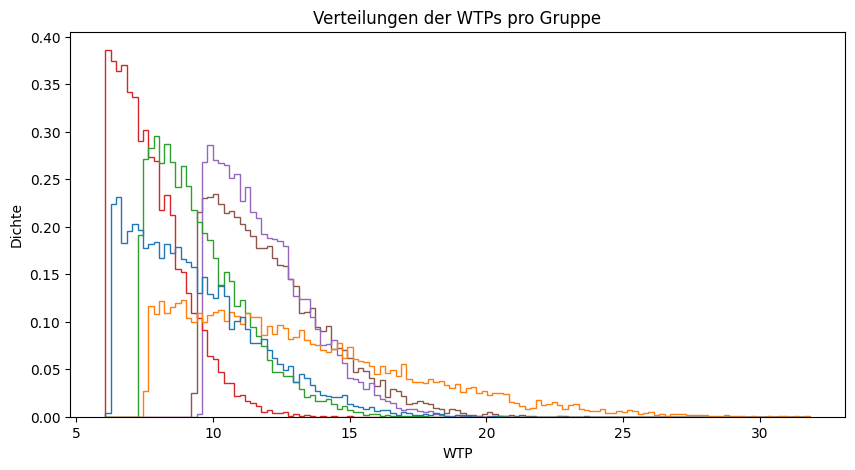

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
r = stats.halfnorm.rvs(size=(N*10, G), scale=wtps_g, loc=wtp_g)
ax.hist(r, density=True, bins='auto', histtype='step', alpha=1)
# ax.set_xlim([x[0], x[-1]])

ax.legend(loc='best', frameon=False)
ax.set_title('Verteilungen der WTPs pro Gruppe')
ax.set_xlabel('WTP')
ax.set_ylabel('Dichte')
plt.show()

In [28]:
wtp_sample = stats.halfnorm.rvs(loc=wtp_g, scale=wtp_g, size=(N, G))

In [9]:
def init_occurences(T, group_sizes) -> list[list[int]]:
    occurences = []

    for g in group_sizes:
        start = np.random.choice(range(10,20))
        end = np.random.choice(range(35,45))

        print(end-start, g)

        occurences.append(
            [0]*start +
            randomList(end-start, g) + 
            [0]*(T-end)
        )

    return occurences


In [27]:
occ = np.array(init_occurences(T, group_sizes))
wtp = [stats.halfnorm.rvs(loc=wtp_g[idx], scale=wtps_g[idx], size=g) for idx, g in enumerate(group_sizes)]

24 166
22 168
28 148
33 214
27 183
29 121


In [30]:
wtp_group_mean = wtp_sample.mean(axis=0)

Text(0.5, 1.0, 'Occurences of groups over time')

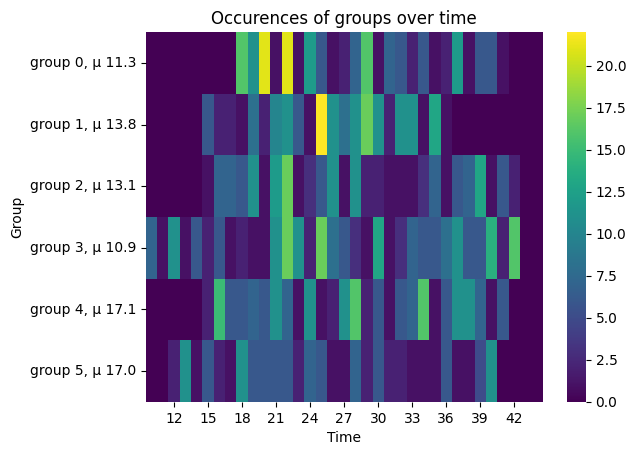

In [31]:
fig, ax = plt.subplots(1, 1)
sns.heatmap(occ, ax=ax, cmap='viridis')
ax.set_xlabel('Time')
ax.set_ylabel('Group')
ax.set_yticklabels(['group {}, µ {}'.format(i, round(wtp_group_mean[i], 1)) for i in range(G)])

ax.set_xlim([10, 45])

# rotate y labels
plt.yticks(rotation=0)

ax.set_title('Occurences of groups over time')

In [32]:
n_offered = np.array(randomList(T, K) )

In [33]:
price = np.random.normal(3, 2, size=T)    

# check: for a price of 0 we should get N individuals who are willing to pay
# price = [0.1] * T

In [34]:
def n_willing_stochastic(price:np.ndarray, occ:np.ndarray, wtp_g:np.ndarray, wtps_g:np.ndarray) -> np.ndarray:
    """
    returns the number of individuals willing to buy a ticket at a given price
    """
    
    
    tickets_bought = [0]*T

    for grp_idx, group in enumerate(occ):
        for t_idx, n_occ in enumerate(group):

            price_t = price[t_idx]

            if n_occ == 0:
                continue

            wtp = stats.halfnorm.rvs(loc=wtp_g[grp_idx], scale=wtps_g[grp_idx], size=n_occ)

            tickets_bought_t = sum(price_t < wtp)
            tickets_bought[t_idx] += tickets_bought_t

            # print(n_occ, wtp, tickets_bought_t, price_t)
        
    return np.array(tickets_bought)

In [35]:
def n_willing_det(price:np.ndarray, occ:np.ndarray, wtp:list[np.ndarray]) -> np.ndarray:
    """
    returns the number of individuals willing to buy a ticket at a given price each time period
    """
    
    
    tickets_bought = [0]*T

    for grp_idx, group in enumerate(occ):
        for t_idx, n_occ in enumerate(group):

            price_t = price[t_idx]

            if n_occ == 0:
                continue

            wtp_g_t = wtp[grp_idx][t_idx: t_idx+n_occ]

            tickets_bought_t = sum(price_t < wtp_g_t)
            tickets_bought[t_idx] += tickets_bought_t

            # print(n_occ, wtp, tickets_bought_t, price_t)
        
    return np.array(tickets_bought)

In [45]:
def n_tickets_sold(n_tickets_offered, n_tickets_willing)->np.ndarray:
    """
    returns the number of tickets sold
    """
    return np.min(np.concatenate([n_tickets_offered.reshape(-1, 1), n_tickets_willing.reshape(-1,1)], axis=1), axis=1)

In [68]:
def objective(price: np.ndarray, n_tickets_offered: np.ndarray) -> float:
    """
    returns the revenue
    """
    global N_EVALS
    N_EVALS += 1

    # n_tickets_willing = n_willing_stochastic(price, occ, wtp_g, wtps_g)
    n_tickets_willing = n_willing_det(price, occ, wtp)
    # print(n_tickets_willing)
    sold = n_tickets_sold(n_tickets_offered, n_tickets_willing)
    # print(sold)
    return sum(sold*price)

In [66]:
objective(population_current[0,0,:], population_current[0,1,:])

[ 0  0  0  0  0  0  0  0  0  0  5  1 13 12  7 17 32 17 42 44 37 49 63 22
 36 58 34 29 55 33 28 13 28 27 33 26 24 41 24 37 23 15  8  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  5.  1. 13. 12.  7.  1.  1.  1.
  1.  2. 37. 40. 23. 22. 28. 39.  1. 29. 31.  1. 28. 13. 24.  1. 33. 26.
 24.  1. 24. 37. 23.  2.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]


3094.9831700763666

In [47]:
def mutate_price(price:np.ndarray) -> np.ndarray:
    """
    mutate the price vector by adding a random value at a random position
    """
    price_new = price.copy()
    price_idx = randint(0, T-1)

    price_new[price_idx] = price[price_idx] + np.random.normal(0, price.std())
    
    return price_new

In [48]:
def mutate_n_tickets_sold(n_tickets_sold:np.ndarray, resample_length: int=3):
    """
    mutate the n_tickets sold by resampling a section of the genes
    """
    n_tickets_sold_new = n_tickets_sold.copy()


    resample_length = resample_length
    idx = randint(0, T-1-resample_length)

    n_tickets_sold_new[idx:idx+resample_length] = randomList(resample_length, K)

    return n_tickets_sold_new

In [73]:
def recombine_price(price1:np.ndarray, price2:np.ndarray):
    """
    recombine two prices
    """
    price_new = price1.copy()

    idx = randint(0, T-1)

    price_new[:idx] = price1[:idx]
    price_new[idx:] = price2[idx:]

    return price_new

def recombine_n_tickets_sold(n_tickets_sold1:np.ndarray, n_tickets_sold2:np.ndarray):
    """
    recombine two n_tickets_sold
    # Note that this recombination can lead to invalid solutions that may exceed capacity
    """
    n_tickets_sold_new = n_tickets_sold1.copy()

    idx = randint(0, T-1)

    n_tickets_sold_new[:idx] = n_tickets_sold1[:idx]
    n_tickets_sold_new[idx:] = n_tickets_sold2[idx:]

    return n_tickets_sold_new

In [50]:
def init_individual():
    return np.random.normal(5, 2, size=T), np.array(randomList(T, K))

## Testing Mutation

In [103]:
best = 0
best_price = None
best_offered = None
improvements = []

for i in range(100):
    price, n_offered = init_individual()

    o = objective(price, n_offered)

    price_mut = mutate_price(price)
    # n_offered_mut = mutate_n_tickets_sold(n_offered)

    o_mut = objective(price_mut, n_offered)

    # if o_mut > o:
    #     best += 1
    #     print(o_mut, o)

    improvements.append(o_mut-o)

# if o > best:
#     best = o
#     best_price = price
#     best_offered = n_offered
#     print(o)

## testing recombination

In [ ]:
best = 0

for i in range(100):
    price1, n_offered1 = init_individual()
    price2, n_offered2 = init_individual()

    o1 = objective(price1, n_offered1)
    o2 = objective(price2, n_offered2)

    price_new = recombine_price(price1, price2)
    n_offered_new = recombine_n_tickets_sold(n_offered1, n_offered2) 

    o_new = objective(price_new, n_offered_new)

    if o_new > o1 and o_new > o2:
        best += 1
        print(o_new, o1, o2)

## Implementing GA

In [118]:
def roulette_selection(individuals, objs: list[float], n_selected: int):
    """
    select individuals based on their objective values
    -> roulette wheel selection
    """
    n = len(individuals)

    # sort individuals by objective value
    sorted_individuals = [ind for _, ind in sorted(zip(objs, individuals), key=lambda pair: pair[0], reverse=True)]
    # select the best n_selected individuals
    return np.array(sorted_individuals[:n_selected])


    # normalize objective values
    objs_arr = np.array(objs)
    objs_norm = objs_arr/objs_arr.sum()

    selected_id =  np.random.choice(range(len(individuals)), size=n_selected, p=objs_norm)

    return np.array([individuals[i] for i in selected_id])


## Testing exponential decay of mutation rate

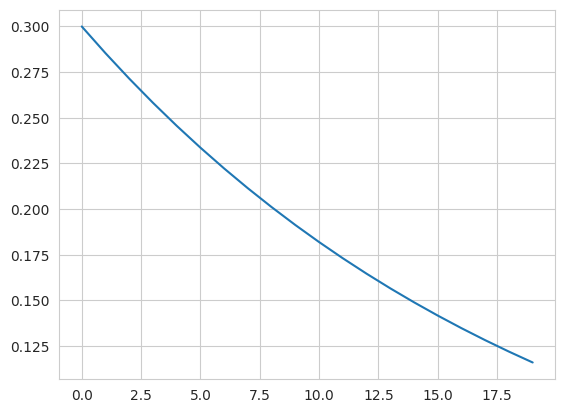

In [134]:
MUT_START = 0.3
MUT_DECAY = 0.05

t = np.arange(20)

# plt.plot(t, MUT_START*MUT_DECAY**t)
plt.plot(t, MUT_START*np.exp(-0.05*t))

In [135]:
N_ITER = 100
POP_SIZE = 100
N_CHILDREN = 100
MUTATION_RATE = 0.30
REAMPLE_LENGTH = 3
N_EVALS = 0

MUT_START = 0.3
MUT_DECAY = 0.05


population_current = np.array([init_individual() for _ in range(POP_SIZE)])
population_hist = [population_current]
obj_stats = []

for i in range(20):
    objs = [objective(*ind) for ind in population_current]
    objs_norm = objs/sum(objs)
    obj_stats.append(objs)

    print(np.array(objs).mean())

    children = []
    valid = 0
    # for j in range(N_CHILDREN):

    # generate children until we have N_CHILDREN valid children
    while valid < N_CHILDREN:

        # sample two parents based on their objective values
        parents = np.random.choice(np.array(range(POP_SIZE)), size=2, p=objs_norm, replace=False)
        
        # recombine parents to obtain new price
        child_price = recombine_price(population_current[parents[0], 0, :], population_current[parents[1], 0, :])
        
        # recombine parents to obtain new n_tickets_sold
        child_offered = recombine_n_tickets_sold(population_current[parents[0], 1, :], population_current[parents[1], 1, :])

        # check if the child is valid
        if sum(child_offered) <= K:
            valid += 1
            children.append([child_price, child_offered])

    # mutate the children
    for child in children:
        # if np.random.rand() < MUTATION_RATE:
        if np.random.rand() < MUT_START*np.exp(-MUT_DECAY*i):
            child[0] = mutate_price(child[0])
            child[1] = mutate_n_tickets_sold(child[1], resample_length=REAMPLE_LENGTH)

    objs_new = [objective(*ind) for ind in children]

    # temporarily add children to population
    population_current = np.concatenate([population_current, children], axis=0)

    # reduce population size again
    population_current = roulette_selection(population_current, np.concatenate([objs, objs_new]), n_selected=POP_SIZE)

    population_hist.append(population_current)

269.57356201894453
340.2364496009041
396.9915335612657
457.3280244206227
513.4199707424394
577.7602693104199
648.8941289690332
695.5501683519344
721.2934804732446
746.2882720120214
761.3508727157432
773.3663250138093
785.3527553587998
792.3613409546668
804.2623784543649
805.457289250503
808.4185320009352
810.9608431673541
811.6476866600706
816.2827833710961


<Axes: title={'center': 'Iteration 0'}, xlabel='Time', ylabel='N Offered'>

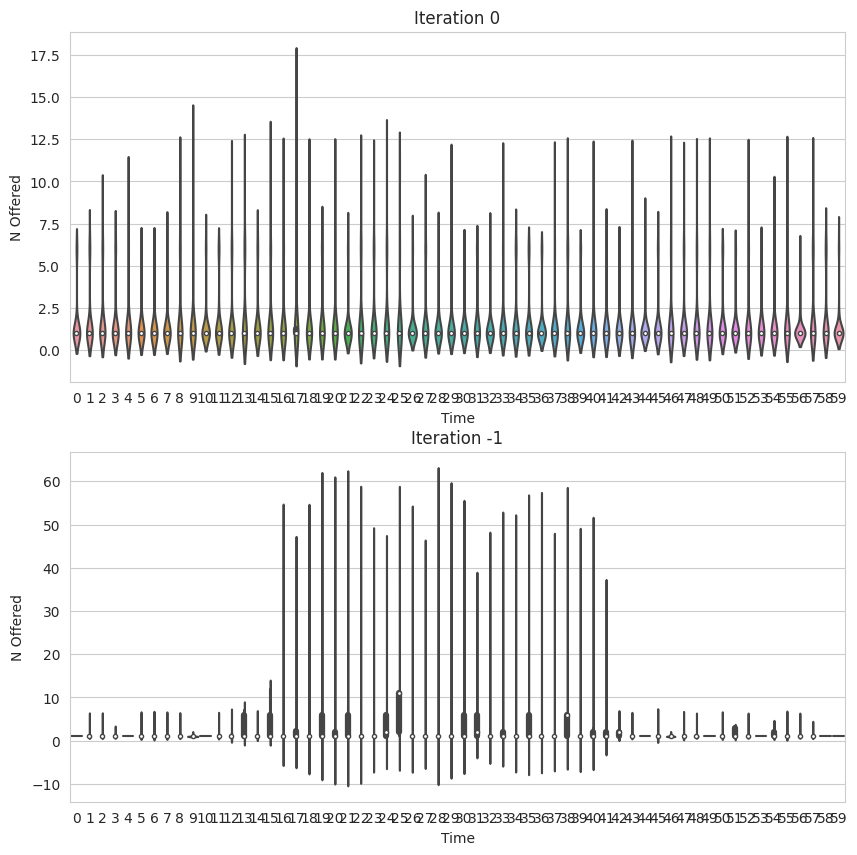

In [136]:
# visualize children
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
# population_current


# title
ax[0].set_title('Iteration 0')
ax[1].set_title('Iteration -1')
for i in range(2):
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('N Offered')

sns.violinplot(data=population_hist[-1][:,1,:], ax=ax[1])
sns.violinplot(data=population_hist[0][:,1,:], ax=ax[0])

In [137]:
obj_stats = np.array(obj_stats)

In [138]:
res = pd.DataFrame(obj_stats).reset_index().melt(id_vars='index').rename(columns={'index': 'iteration', 'variable': 'individual', 'value': 'objective'})

<Axes: xlabel='iteration', ylabel='objective'>

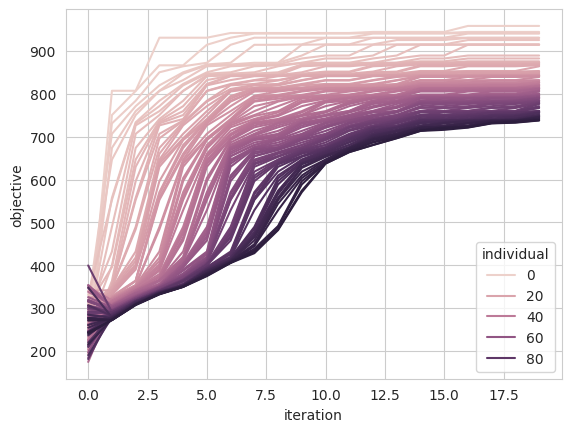

In [139]:
sns.lineplot(data=res, x='iteration', y='objective', hue='individual')

<Axes: title={'center': 'Objective values over iterations'}, xlabel='Iteration', ylabel='Objective value'>

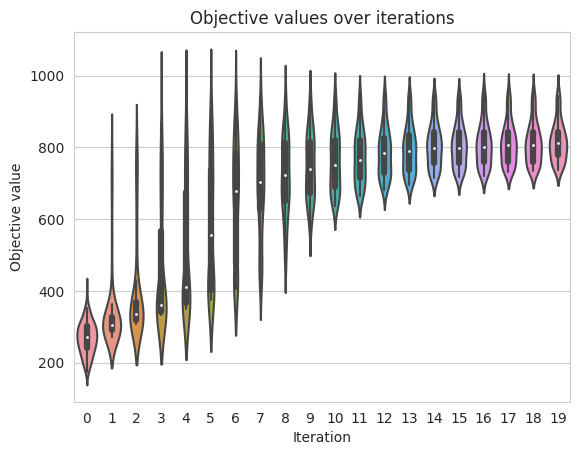

In [140]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 1)
ax.set_title('Objective values over iterations')
ax.set_xlabel('Iteration')
ax.set_ylabel('Objective value')
sns.violinplot(data=obj_stats.T)

In [ ]:
# 2 * T * pop_size * it

In [ ]:
np.random.choice()